#credit card transaction fraud

#loading data

In [1]:
import pandas as pd
import os

training_data_path = "fraudTrain.csv"
test_data_path = "fraudTest.csv"

training_data_raw = pd.read_csv(training_data_path)
test_data_raw = pd.read_csv(test_data_path)

#cleaning data

In [2]:
#data cleaning here
training_data_clean = {"cc_num": [], "merchant": [], "category": [], "amt": [], "first": [], "last": [], "gender": [], "lat": [], "long": [], "city_pop": [], "job": [], "unix_time": [], "merch_lat": [], "merch_long": [], "is_fraud": []}
for idx in range(len(training_data_raw["cc_num"])):
    for key in training_data_clean.keys():
        training_data_clean[key].append(training_data_raw[key][idx])
training_data_clean = pd.DataFrame.from_dict(training_data_clean)
training_data_clean.to_csv("credit_card_fraud_clean_train.csv", index=False)

test_data_clean = {"cc_num": [], "merchant": [], "category": [], "amt": [], "first": [], "last": [], "gender": [], "lat": [], "long": [], "city_pop": [], "job": [], "unix_time": [], "merch_lat": [], "merch_long": [], "is_fraud": []}
for idx in range(len(test_data_raw["cc_num"])):
    for key in test_data_clean.keys():
        test_data_clean[key].append(test_data_raw[key][idx])
test_data_clean = pd.DataFrame.from_dict(test_data_clean)
test_data_clean.to_csv("credit_card_fraud_clean_test.csv", index=False)

#Preprocess data for neural network

In [3]:
#Handle subselection of columns for the neural network
#columns to keep: cc_num, merchant, category, amt, lat, long, unix_time, merch_lat, merch_long, is_fraud

#find unique merchants
unique_merchants = set(list(training_data_clean["merchant"]))
for merchant in list(test_data_clean["merchant"]):
    unique_merchants.add(merchant)
unique_merchants = list(unique_merchants)
print(len(unique_merchants))

#create tokenization scheme for merchants
merchant_tokenized_dict = {}
for idx in range(len(unique_merchants)):
    merchant_tokenized_dict[unique_merchants[idx]] = idx

#find unique categories
unique_categories = set(list(training_data_clean["category"]))
for category in list(test_data_clean["category"]):
    unique_categories.add(category)
unique_categories = list(unique_categories)
print(len(unique_categories))

#create tokenization scheme for categories
categories_tokenized_dict = {}
for idx in range(len(unique_categories)):
    categories_tokenized_dict[unique_categories[idx]] = idx

#columns to keep: merchant, category, amt, lat, long, unix_time, merch_lat, merch_long, is_fraud
#create non-categorical data list
non_categorical = []
for idx in range(len(training_data_clean["cc_num"])):
    element = []
    #element.append(training_data_clean["cc_num"][idx])
    element.append(training_data_clean["amt"][idx])
    element.append(training_data_clean["lat"][idx])
    element.append(training_data_clean["long"][idx])
    element.append(training_data_clean["unix_time"][idx])
    element.append(training_data_clean["merch_lat"][idx])
    element.append(training_data_clean["merch_long"][idx])
    non_categorical.append(element)
print("Non-categorical data length:", len(non_categorical))

from keras.utils import to_categorical
#format merchant column as one-hot list
num_unique_merchants = len(unique_merchants)
merchant_categorical = []
for idx in range(len(training_data_clean["merchant"])):
    element_raw = training_data_clean["merchant"][idx]
    element_int = merchant_tokenized_dict[element_raw]
    merchant_categorical.append(to_categorical(element_int, num_classes=num_unique_merchants))
print("Merchant data length:", len(merchant_categorical))

#format category data as one-hot list
num_unique_categories = len(unique_categories)
category_one_hot = []
for idx in range(len(training_data_clean["category"])):
    element_raw = training_data_clean["category"][idx]
    element_int = categories_tokenized_dict[element_raw]
    category_one_hot.append(to_categorical(element_int, num_classes=num_unique_categories))
print("Category length:", len(category_one_hot))

#create is_fraud list as y column
fraud_column = []
num_fraud = 0
for idx in range(len(training_data_clean["is_fraud"])):
    fraud_val = training_data_clean["is_fraud"][idx]
    num_fraud += fraud_val
    fraud_column.append([fraud_val])
print("Fraud length:", len(fraud_column))
print("Number of fraudulent transactions:", num_fraud)

693
14
Non-categorical data length: 1296675
Merchant data length: 1296675
Category length: 1296675
Fraud length: 1296675
Number of fraudulent transactions: 7506


#subsample data

In [4]:
import random
##find all fraud in training data
fraud_data_merchant_sample = []
fraud_data_category_sample = []
fraud_data_non_categorical_sample = []
fraud_data_label_sample = []
for idx in range(len(training_data_clean["is_fraud"])):
    #if the row at idx represents fraud
    if(training_data_clean["is_fraud"][idx] == 1):
        #add data to fraud data samples according to data type
        fraud_data_non_categorical_sample.append(non_categorical[idx])
        fraud_data_category_sample.append(category_one_hot[idx])
        fraud_data_merchant_sample.append(merchant_categorical[idx])
        fraud_data_label_sample.append([1])
##add subsample of non-fraud data with equal number of rows to fraud data in training data
max_index = len(training_data_clean["is_fraud"]) - 1
num_safe_transactions_included = 0
while num_safe_transactions_included < num_fraud:
    #select random row index in the formatted fraud data above
    random_index = random.randint(0, max_index)
    #if this data does not represent a fraudulent transaction
    if(training_data_clean["is_fraud"][random_index] == 0):
        #add the data to fraud_data samples accordingly
        fraud_data_non_categorical_sample.append(non_categorical[random_index])
        fraud_data_category_sample.append(category_one_hot[random_index])
        fraud_data_merchant_sample.append(merchant_categorical[random_index])
        fraud_data_label_sample.append([0])
    num_safe_transactions_included += 1

import numpy as np

fraud_data_non_categorical_sample = np.array(fraud_data_non_categorical_sample)
print("Non-categorical shape:", fraud_data_non_categorical_sample.shape)
fraud_data_merchant_sample = np.array(fraud_data_merchant_sample)
print("Merchant shape:", fraud_data_merchant_sample.shape)
fraud_data_category_sample = np.array(fraud_data_category_sample)
print("Category shape:", fraud_data_category_sample.shape)
fraud_data_label_sample = np.array(fraud_data_label_sample)
print("Label shape:", fraud_data_label_sample.shape)

Non-categorical shape: (14968, 6)
Merchant shape: (14968, 693)
Category shape: (14968, 14)
Label shape: (14968, 1)


#Keras environment setup

In [5]:
#load ML libraries
import hyperopt

from hyperopt import fmin, tpe

from keras.models import Model, load_model
from keras.layers import Dense, Dropout, Input, concatenate

from keras import activations
from keras import callbacks
from keras import regularizers
from keras.utils import plot_model

from sklearn.model_selection import KFold

#define method for generating model
def define_model(num_nodes, dropout, kernel_reg, bias_reg):
    #define input nodes
    input_non_categorical = Input(shape=(6,))
    input_merchant_category = Input(shape=(693,))
    input_purchase_category = Input(shape=(14,))
    #define processing
    concat_input = concatenate(inputs=[input_non_categorical, input_merchant_category, input_purchase_category])
    dense_layer_1 = Dense(num_nodes, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_reg), bias_regularizer=regularizers.l2(bias_reg))(concat_input)
    dropout_layer_1 = Dropout(dropout)(dense_layer_1)
    dense_layer_2 = Dense(num_nodes // 2, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_reg), bias_regularizer=regularizers.l2(bias_reg))(dropout_layer_1)
    concat_tail = concatenate(inputs=[dense_layer_2, input_non_categorical, input_purchase_category])
    #dropout_layer_2 = Dropout(dropout / 2)(concat_tail)
    #dense_layer_3 = Dense(num_nodes // 2, activation=activations.relu, kernel_regularizer=regularizers.l2(kernel_reg), bias_regularizer=regularizers.l2(bias_reg))(dropout_layer_2)
    #define output
    output = Dense(1, activation=activations.sigmoid)(concat_tail)
    #output = Dense(1, activation=activations.sigmoid)(dense_layer_3)
    #compile and return
    network = Model(inputs=[input_non_categorical, input_merchant_category, input_purchase_category], outputs=output)
    #network = Model(inputs=[input_non_categorical, input_purchase_category], outputs=output)
    network.compile(loss="binary_crossentropy")
    return network

#hyperparameter Tuning

In [6]:
#do hyperparameter tuning here
import math
import numpy as np

best_loss = math.inf
best_params = ()

def average(data_list):
    avg = 0
    for idx in range(len(data_list)):
        if not np.isnan(data_list[idx]):
            avg += data_list[idx]
        else:
            avg += 10
    avg /= len(data_list)
    return avg

def get_average_cross_validation_accuracy(args):
    global best_loss, best_params
    max_node_count, dropout, kernel_regularization, bias_regularization = args
    data_split = KFold(n_splits=5, shuffle=True)
    loss_vals = []
    callbacks_list = [callbacks.EarlyStopping(monitor='val_loss', patience=1,), callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=1,)]
    for train_index, test_index in data_split.split(fraud_data_non_categorical_sample, fraud_data_label_sample):
        #convert data into train and test data
        non_categorical_train, non_categorical_test = fraud_data_non_categorical_sample[train_index], fraud_data_non_categorical_sample[test_index]
        merchant_cat_train, merchant_cat_test = fraud_data_merchant_sample[train_index], fraud_data_merchant_sample[test_index]
        purchase_cat_train, purchase_cat_test = fraud_data_category_sample[train_index], fraud_data_category_sample[test_index]
        label_train, label_test = fraud_data_label_sample[train_index], fraud_data_label_sample[test_index]
        network = define_model(max_node_count, dropout, kernel_regularization, bias_regularization)
        network.fit(x=[non_categorical_train, merchant_cat_train, purchase_cat_train], y=label_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=callbacks_list, verbose=0)
        evaluation = network.evaluate(x=[non_categorical_test, merchant_cat_test, purchase_cat_test], y=label_test, verbose=0)
        #network.fit(x=[non_categorical_train, purchase_cat_train], y=label_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=callbacks_list, verbose=0)
        #evaluation = network.evaluate(x=[non_categorical_test, purchase_cat_test], y=label_test, verbose=0)
        loss_vals.append(evaluation)
        del network
        del non_categorical_train, non_categorical_test
        del merchant_cat_train, merchant_cat_test
        del label_train, label_test
    average_loss = average(loss_vals)
    if average_loss < best_loss:
        best_params = args
        best_loss = average_loss
    return average_loss

def optimize_hyperparameters():
    max_node_counts = [64, 128, 256, 512]
    dropout_values = [0.2, 0.3, 0.4, 0.5]
    kernel_reg_list = [0.01, 0.025, 0.05]
    bias_reg_list = [0.01, 0.025, 0.05]
    case_list = []
    for max_node_count in max_node_counts:
        for dropout_value in dropout_values:
            for kernel_reg in kernel_reg_list:
                for bias_reg in bias_reg_list:
                    case_list.append((max_node_count, dropout_value, kernel_reg, bias_reg))
    feature_space = hyperopt.hp.choice('a', case_list)
    fmin(get_average_cross_validation_accuracy, feature_space, algo=tpe.suggest, max_evals=128)

optimize_hyperparameters()
print("Best parameters:", best_params)
print("Best loss:", best_loss)

100%|██████████| 128/128 [16:41<00:00,  7.82s/trial, best loss: 717573.9015625]
Best parameters: (64, 0.5, 0.05, 0.01)
Best loss: 717573.9015625


#Train Neural Network

Epoch 1/20
 1/94 [..............................] - ETA: 0s - loss: 137618080.0000WARNING:tensorflow:From C:\Users\cmyth\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
94/94 [==============================] - 1s 6ms/step - loss: 27542134.0000 - val_loss: 31177206.0000
Epoch 2/20
94/94 [==============================] - 0s 4ms/step - loss: 12256916.0000 - val_loss: 32311076.0000


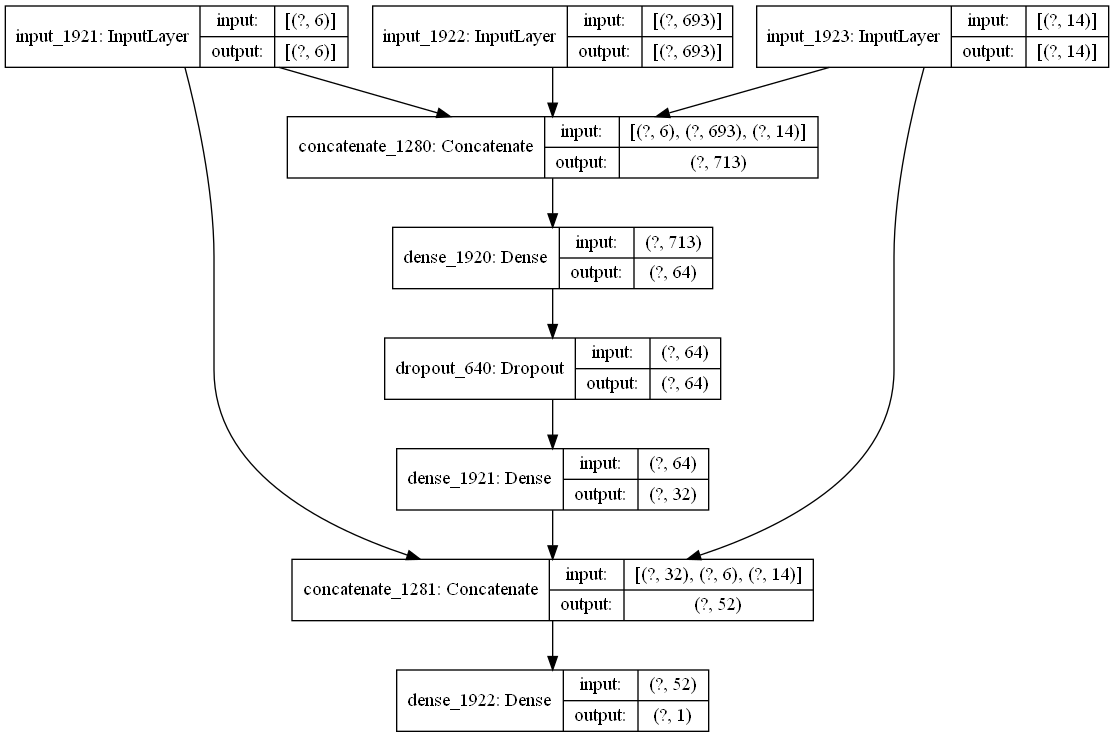

In [7]:
#Train neural network here
import os
os.mkdir("cc_fraud_detector")

callbacks_list = [callbacks.EarlyStopping(monitor='val_loss', patience=1,), callbacks.ModelCheckpoint(filepath='cc_fraud_detector.h5', monitor='val_loss', save_best_only=True,), callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=1,), callbacks.TensorBoard(log_dir="cc_fraud_detector",histogram_freq=1,embeddings_freq=1,)]
try:
    max_node_count, dropout_value, kernel_reg, bias_reg = best_params
except:
    max_node_count, dropout_value, kernel_reg, bias_reg = 64, 0.2, 0.025, 0.01

network = define_model(max_node_count, dropout_value, kernel_reg, bias_reg)
history = network.fit(x=[fraud_data_non_categorical_sample, fraud_data_merchant_sample, fraud_data_category_sample], y=fraud_data_label_sample, epochs=20, batch_size=128, validation_split=0.2, callbacks=callbacks_list)
#history = network.fit(x=[fraud_data_non_categorical_sample, fraud_data_category_sample], y=fraud_data_label_sample, epochs=20, batch_size=128, validation_split=0.2, callbacks=callbacks_list)
plot_model(network, to_file='cc_fraud_detector.png', show_shapes=True)

#False positive and negative rates

In [8]:
#initialize false positive and negative rates
false_pos = 0
false_neg = 0
true_pos = 0
true_neg = 0

#load credit_card_fraud_clean_test.csv and format
test_data_non_categorical = []
test_data_product_category = []
test_data_fraud_value = []
for idx in range(len(test_data_clean["cc_num"])):
    non_categorical_element = []
    #element.append(training_data_clean["cc_num"][idx])
    non_categorical_element.append(test_data_clean["amt"][idx])
    non_categorical_element.append(test_data_clean["lat"][idx])
    non_categorical_element.append(test_data_clean["long"][idx])
    non_categorical_element.append(test_data_clean["unix_time"][idx])
    non_categorical_element.append(test_data_clean["merch_lat"][idx])
    non_categorical_element.append(test_data_clean["merch_long"][idx])
    test_data_non_categorical.append(non_categorical_element)
    categorical_element = to_categorical(categories_tokenized_dict[test_data_clean["category"][idx]], num_classes=num_unique_categories)
    test_data_product_category.append(categorical_element)
    test_data_fraud_value.append([test_data_clean["is_fraud"][idx]])

test_data_non_categorical = np.array(test_data_non_categorical)
test_data_product_category = np.array(test_data_product_category)
test_data_fraud_value = np.array(test_data_fraud_value)

#Evaluate on test set

In [9]:
#evaluate